#Experimentation using RNN
Notebook with the experimentation for the Time Series Forecasting Using Artificial Neural Networks paper to presented in IGPL 2022



In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import sys
path = '/content/drive/My Drive/Research Papers/IGPL 2022/'
directory = path + 'src/'
sys.path.append(directory)

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [93]:
import statsmodels.api as sm

In [115]:
series = y_train[:,0]

In [120]:
model = sm.tsa.ARIMA(series, order=(1, 1, 0))  # ARIMA(1, 0, 0) model
model_fit = model.fit()

In [117]:
# Forecast one period ahead
forecast = model_fit.forecast(steps=len(series))
forecast

array([0.50688277, 0.50733086, 0.50777561, ..., 0.56711954, 0.56711954,
       0.56711954])

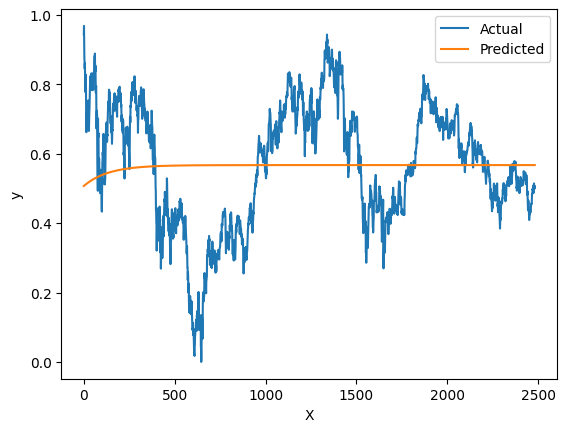

In [119]:
plt.plot(series, label='Actual')
plt.plot(forecast, label='Predicted')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

ValueError: ignored

In [16]:
import numpy as np
import pandas as pd
from ann import training, model_LSTM_1, model_GRU_1, model_LSTM_2, model_RNN_1
from ann_mlp import model_MLP_1
from utils import preprocessing, plotting, metrics

In [17]:
np.random.seed(0)
data_original = pd.read_csv(path+'data/IBEX35.csv')
data_original.describe

<bound method NDFrame.describe of             Date    Close     Open      Max      Min  Volume
0     02-12-2022   8382.6   8390.0   8414.1   8342.3  146.28
1     01-12-2022   8407.9   8426.2   8469.0   8381.8  209.72
2     30-11-2022   8363.2   8350.4   8364.6   8304.4  325.06
3     29-11-2022   8322.1   8348.5   8354.5   8282.8  145.89
4     28-11-2022   8323.2   8380.7   8396.4   8316.7  125.89
...          ...      ...      ...      ...      ...     ...
3304  08-01-2010  12163.0  12218.0  12232.2  12079.9  213.11
3305  07-01-2010  12166.3  12163.0  12199.7  12079.1  192.31
3306  06-01-2010  12222.5  12216.4  12230.7  12147.6  123.74
3307  05-01-2010  12204.4  12141.8  12240.5  12139.8  238.43
3308  04-01-2010  12145.1  11986.5  12145.1  11986.1  184.13

[3309 rows x 6 columns]>

In [18]:
data_original_inv = data_original.iloc[::-1]

In [19]:
preprocessing.normality_test(data_original_inv['Close'])

The null hypothesis can be rejected
With a value of 2.4812615646047063e-18
It's not normally distributed


In [20]:
data = data_original_inv.drop(columns="Date")
data_norma = preprocessing.norma(data, True)

In [21]:
num_epochs = 1 #1000
learning_rate = 0.001

In [22]:
models = ["LSTM 1", "GRU 1", "LSTM 2", "RNN 1", "MLP 1"]

In [23]:
expr_m = {"LSTM 1":[[1,1],[2,18],[2,32],[4,64],[4,128],[8,128]], "GRU 1":[[1,1],[2,18],[2,32],[4,64],[4,128],[8,128]], "LSTM 2":[[1,1],[2,18],[2,32],[4,64],[4,128],[8,128]],
          "RNN 1":[[1,1],[2,18],[2,32],[4,64],[4,128],[8,128]], "MLP 1":[[1,1],[2,18],[2,32],[4,64],[4,128],[8,128]]}

In [85]:
results = []
n_class = 0
for t in range(3):
    n_class = n_class+1
    for i in range(6):
        input_size = 8
        hidden_n = 2
        dropout_prob = 0.2
        silent_mode = True
        split_at = 2482

        X, y = preprocessing.get_steps(data_norma['Close'], data_norma['Volume'], n_class)
        X_train, X_test, y_train, y_test = preprocessing.splitting(X,y, split_at)


        X_train_tensors, X_test_tensors, y_train_tensors, y_test_tensors = training.convert_tensor(X_train,X_test,y_train,y_test)
        X_train_tensors_final = training.reshape_3d(X_train_tensors, X_train_tensors.shape[0], 1, X_train_tensors.shape[1])
        X_test_tensors_final = training.reshape_3d(X_test_tensors, X_test_tensors.shape[0], 1, X_test_tensors.shape[1])

        lstm1 = model_LSTM_1(input_size, n_class,expr_m["LSTM 1"][i][0], expr_m["LSTM 1"][i][1], dropout_prob)
        gru1 = model_GRU_1(input_size, n_class, expr_m["GRU 1"][i][0], expr_m["GRU 1"][i][1], dropout_prob)
        lstm2 = model_LSTM_2(input_size, n_class, expr_m["LSTM 2"][i][0], expr_m["LSTM 2"][i][1], dropout_prob)
        rnn1 = model_RNN_1(input_size, n_class, expr_m["RNN 1"][i][0], expr_m["RNN 1"][i][1], dropout_prob)
        mlp1 = model_MLP_1(input_size, n_class, expr_m["MLP 1"][i][0], expr_m["MLP 1"][i][1], "sigmoid")

        prediction_1, running_time1 = training.training_iteration(num_epochs, learning_rate, lstm1, X_train_tensors_final, X_test_tensors_final, y_train_tensors, silent_mode)
        spc_1 = str(expr_m["LSTM 1"][i][0])+" hidden nodes + "+str(expr_m["LSTM 1"][i][1])+" layers"
        results.append([models[0], str(i+1), n_class-1, spc_1,metrics.mse(y_test, prediction_1),metrics.mae(y_test, prediction_1),metrics.r2(y_test, prediction_1),running_time1, prediction_1.tolist()])

        prediction_2, running_time2 = training.training_iteration(num_epochs, learning_rate, gru1, X_train_tensors_final, X_test_tensors_final, y_train_tensors, silent_mode)
        spc_2 = str(expr_m["GRU 1"][i][0])+" hidden nodes + "+str(expr_m["GRU 1"][i][1])+" layers"
        results.append([models[1], str(i+1), n_class-1, spc_2,metrics.mse(y_test, prediction_2),metrics.mae(y_test, prediction_2),metrics.r2(y_test, prediction_2),running_time2, prediction_2.tolist()])

        prediction_3, running_time3 = training.training_iteration(num_epochs, learning_rate, lstm2, X_train_tensors_final, X_test_tensors_final, y_train_tensors, silent_mode)
        spc_3 = str(expr_m["LSTM 2"][i][0])+" hidden nodes + "+str(expr_m["LSTM 2"][i][1])+"  layers + 128"
        results.append([models[2], str(i+1), n_class-1, spc_3,metrics.mse(y_test, prediction_3),metrics.mae(y_test, prediction_3),metrics.r2(y_test, prediction_3),running_time3, prediction_3.tolist()])

        prediction_4, running_time4 = training.training_iteration(num_epochs, learning_rate, rnn1, X_train_tensors_final, X_test_tensors_final, y_train_tensors, silent_mode)
        spc_4 = str(expr_m["RNN 1"][i][0])+" hidden nodes + "+str(expr_m["RNN 1"][i][1])+" layers"
        results.append([models[3], str(i+1), n_class-1, spc_4,metrics.mse(y_test, prediction_4),metrics.mae(y_test, prediction_4),metrics.r2(y_test, prediction_4),running_time4, prediction_4.tolist()])

        prediction_5, running_time5 = mlp1.training(num_epochs, learning_rate, X_train, y_train, X_test)
        spc_5 = str(expr_m["MLP 1"][i][0])+" - "+str(expr_m["MLP 1"][i][1])+' layers'
        results.append([models[4], str(i+1), n_class-1, spc_5,metrics.mse(y_test, prediction_5),metrics.mae(y_test, prediction_5),metrics.r2(y_test, prediction_5),running_time5, prediction_5.tolist()])



    np.savetxt(path+"/results/y_test_array_B_"+str(t)+".csv", np.array(y_test), delimiter=",")

In [25]:
results_df = pd.DataFrame(results, columns=['Model','Configuration','t','Specifications','MSE','MAE','R2','Running Time', 'Predictions'])
results_df.head()

,Model,Configuration,t,Specifications,MSE,MAE,R2,Running Time,Predictions
0,LSTM 1,1,0,1 hidden nodes + 1 layers,1.794775,1.333472,-99.610264,0.004114,"[[-0.958111047744751], [-0.9560084342956543], ..."
1,GRU 1,1,0,1 hidden nodes + 1 layers,0.040166,0.157409,-1.251614,0.003039,"[[0.4539448618888855], [0.45290589332580566], ..."
2,LSTM 2,1,0,1 hidden nodes + 1 layers + 128,0.471064,0.673178,-25.406573,0.008200,"[[-0.30315545201301575], [-0.3035019040107727]..."
3,RNN 1,1,0,1 hidden nodes + 1 layers,0.032456,0.157794,-0.819379,0.004323,"[[0.27817946672439575], [0.2738513946533203], ..."
4,MLP 1,1,0,1 - 1 layers,0.027689,0.127232,-0.552174,0.000935,"[[0.4695323368258513], [0.4695282329824559], [..."


In [26]:
time_string = time.strftime("%d_%m_%Y-%H_%M_%S", time.localtime())
results_df.to_csv(path+"/results/final_results_"+time_string+'.csv')

In [27]:
results_df.to_pickle(path+"/results/final_results_"+time_string+'.pickle')